Kaggle Dataset Diabetes, Hypertensionand Stroke Prediction:https://www.kaggle.com/datasets/prosperchuks/health-dataset/data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

Used to shuffle the dataset so that the predictions are not unevely measured.

In [2]:
import io

In [3]:
#Change these paths as needed
data_path = "diabetes_data.csv"
shuffled_data_path =  "shuffled_diabetes_data.csv"

In [4]:
# Load the dataset
df = pd.read_csv(data_path)

#Shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Save the shuffled dataframe to a new CSV file
df_shuffled.to_csv(shuffled_data_path, index=False)

# Phase 1

Dataset shape: (70692, 18)
    Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0  10.0  0.0       1.0        1.0  23.0     1.0                   0.0   
1  13.0  0.0       0.0        1.0  33.0     1.0                   0.0   
2   8.0  1.0       1.0        1.0  27.0     1.0                   0.0   
3   7.0  1.0       1.0        1.0  29.0     1.0                   0.0   
4   6.0  1.0       0.0        1.0  47.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0           1.0     0.0      1.0                0.0      4.0       0.0   
1           0.0     1.0      1.0                0.0      3.0       0.0   
2           1.0     1.0      1.0                0.0      2.0       0.0   
3           0.0     1.0      0.0                0.0      3.0       0.0   
4           1.0     1.0      1.0                0.0      4.0      30.0   

   PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0       0.0       0.0     0.0     0.0  

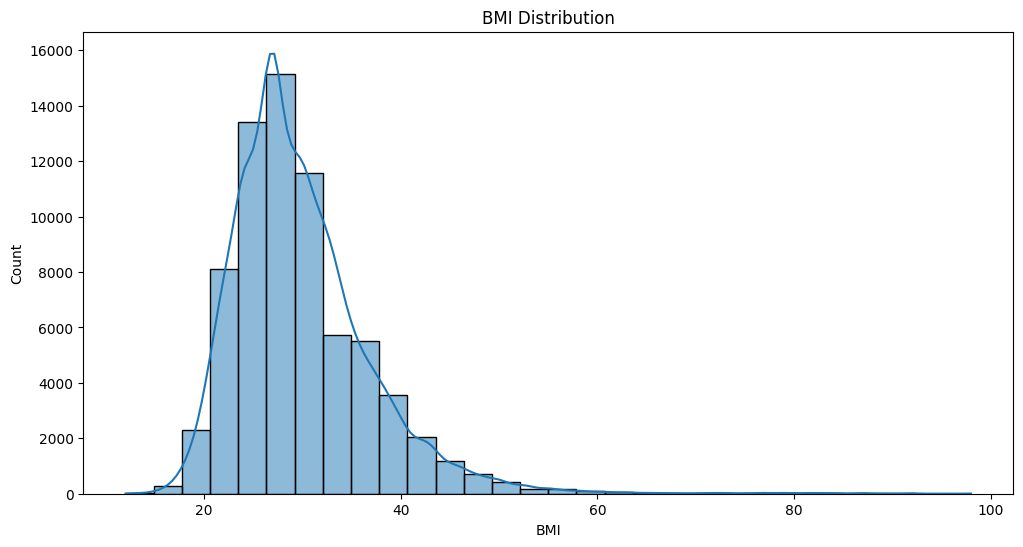

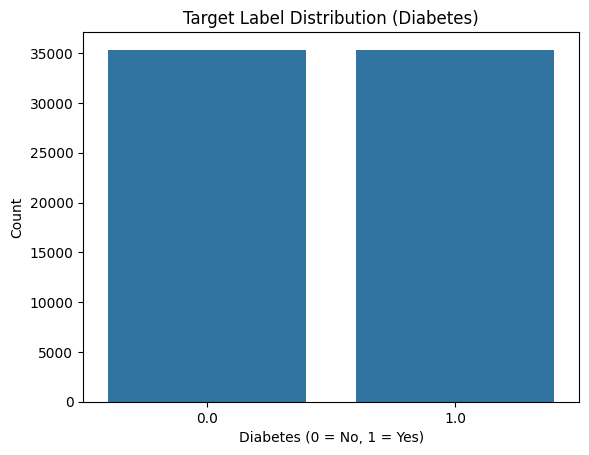

In [5]:

# Display dataset shape and first few rows
print("Dataset shape:", df_shuffled.shape)
print(df_shuffled.head())

# Check for null values
print("\nMissing values:")
print(df_shuffled.isnull().sum())

# Target column: Diabetes (0 or 1)
# Separate features and target
X = df_shuffled.drop(columns=['Diabetes'])
y = df_shuffled['Diabetes']

# Normalize numeric input features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

# Print resulting shapes
print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Plot feature distribution examples
plt.figure(figsize=(12, 6))
sns.histplot(X['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

sns.countplot(x=y)
plt.title('Target Label Distribution (Diabetes)')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


# Phase 2

Overfitting the data

In [6]:
# Store results
results = []

# Function to build and train model
def train_and_evaluate_model(hidden_layers, neurons_per_layer, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(X_scaled, y, epochs=200, verbose=0)
    final_acc = history.history['accuracy'][-1]
    results.append((f"{neurons_per_layer}-neuron x {hidden_layers}-layer", final_acc))
    return model, history

In [7]:
# Test model configurations
layer_sizes = [1, 2, 3]
neuron_options = [1, 2, 4, 8, 16, 32, 64]

for layers in layer_sizes:
    for neurons in neuron_options:
        print(f"Training model: {neurons} neurons x {layers} layers")
        model, history = train_and_evaluate_model(layers, neurons, X_scaled.shape[1])
        if history.history['accuracy'][-1] >= 0.99:
            break  # Stop if we overfit

Training model: 1 neurons x 1 layers
Training model: 2 neurons x 1 layers
Training model: 4 neurons x 1 layers
Training model: 8 neurons x 1 layers
Training model: 16 neurons x 1 layers
Training model: 32 neurons x 1 layers
Training model: 64 neurons x 1 layers
Training model: 1 neurons x 2 layers
Training model: 2 neurons x 2 layers
Training model: 4 neurons x 2 layers
Training model: 8 neurons x 2 layers
Training model: 16 neurons x 2 layers
Training model: 32 neurons x 2 layers
Training model: 64 neurons x 2 layers
Training model: 1 neurons x 3 layers
Training model: 2 neurons x 3 layers
Training model: 4 neurons x 3 layers
Training model: 8 neurons x 3 layers
Training model: 16 neurons x 3 layers
Training model: 32 neurons x 3 layers
Training model: 64 neurons x 3 layers


In [8]:
# Show results
print("\nOverfitting Results:")
for config, acc in results:
    print(f"{config} => Training Accuracy: {acc:.4f}")


Overfitting Results:
1-neuron x 1-layer => Training Accuracy: 0.7466
2-neuron x 1-layer => Training Accuracy: 0.7491
4-neuron x 1-layer => Training Accuracy: 0.7517
8-neuron x 1-layer => Training Accuracy: 0.7517
16-neuron x 1-layer => Training Accuracy: 0.7551
32-neuron x 1-layer => Training Accuracy: 0.7559
64-neuron x 1-layer => Training Accuracy: 0.7576
1-neuron x 2-layer => Training Accuracy: 0.7475
2-neuron x 2-layer => Training Accuracy: 0.7495
4-neuron x 2-layer => Training Accuracy: 0.7518
8-neuron x 2-layer => Training Accuracy: 0.7536
16-neuron x 2-layer => Training Accuracy: 0.7556
32-neuron x 2-layer => Training Accuracy: 0.7614
64-neuron x 2-layer => Training Accuracy: 0.7794
1-neuron x 3-layer => Training Accuracy: 0.4963
2-neuron x 3-layer => Training Accuracy: 0.4979
4-neuron x 3-layer => Training Accuracy: 0.4999
8-neuron x 3-layer => Training Accuracy: 0.7532
16-neuron x 3-layer => Training Accuracy: 0.7587
32-neuron x 3-layer => Training Accuracy: 0.7689
64-neuron 

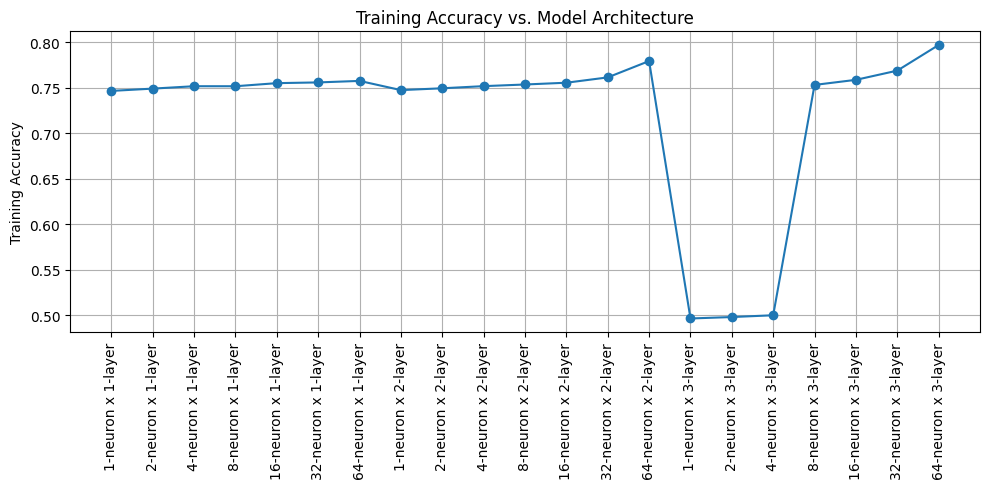

In [9]:
# Plot accuracy vs model size
labels = [config for config, acc in results]
accuracies = [acc for config, acc in results]

plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o')
plt.xticks(rotation=90)
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs. Model Architecture")
plt.grid(True)
plt.tight_layout()
plt.show()